# part0: imports

In [2]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
from typing import Callable
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")



import pandas as pd
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline
reload(dt)

root = pathlib.Path("/data")

# Compare different epochs

the idea is to see whether canonical axes between 2 animals provide a higher VAF for time epochs in the trial that they have not been trained on, compared to, for example, M1-PMd axes in a single animal.

preprocessing

In [3]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

Based on the Gallego Nat Comm 2018 paper and some playing (data and projection matrices in the paper are row-wise): 
$$\%VAF=\frac{norm(X)-norm(X-XC^TA(A^TA)^{-1}A^TC)}{norm(X)}$$
where:
- $A$ is the CCA output, the output of the `canoncorr` function
- $C$ is the `PCA_model.components_`
- $X$ is the data matrix, $T\times n$ with $T$ time points and $n$ neurons, and each neuron is **zero mean**
- $norm$ is sum of squared elements  

Seems to give reasonable results: lowering number of PCs reduces the VAF.

However, there are problems:
- the formulation in the paper, gives a VAF for each dimension, so the formula above should be applied to individual axes.
- It is already implemented in MATLAB [here](https://github.com/limblab/proc-juan/blob/65dd81a1fc0ddb23def8039df9053a2be3e9bf88/paper_cross-task_manifold_review/vaf_CCs.m#L114), which uses the VAF function from the dPCA paper [here](https://github.com/machenslab/dPCA/blob/master/matlab/dpca_explainedVariance.m). I should translate that to compare?!?

> The value above actually equals to the total VAF :)

### dimension-wise VFA

done!

---

back to the original idea:

1. this:
> # Compare different e
pochs
> the idea is to see whether canonical axes between 2 animals provide a higher VAF for time epochs in the trial that they have not been trained on, compared to, for example, M1-PMd axes in a single animal.

2. and a similar but different idea:
> two monkeys during the same epoch vs. one monkey between 2 different epochs.
i.e., preparation vs execution, ...

3. upper bound for VAF and for CCs:
> within monkey and epoch and even target-matched, randomly select 2 subset of trials and the VAF/CCs will be the upper bound.

#### Try the second idea first:

In [4]:
animalList = ['Chewie', 'Mihili']

animalFiles={}
for animal in animalList:
    animalFiles[animal] = utility.find_file(root / animal,'mat')

# just keeping the CS sessions
goodFiles = [file for animal in animalFiles for file in animalFiles[animal] if 'CS' in file]

# keeping 1 session per animal
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat', '/data/Mihili/Mihili_CO_VR_2014-03-03.mat']
# fileList = goodFiles


df_data=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)
    dt.summary(df)

Chewie 10-14-2016
time signals:['pos', 'vel', 'acc', 'force', 'M1_spikes', 'PMd_spikes']
M1_spikes units: 88
PMd_spikes units: 190
tasks in file: ['CO'], epochs: ['BL']

Mihili 03-03-2014
time signals:['pos', 'vel', 'acc', 'force', 'M1_spikes', 'PMd_spikes']
M1_spikes units: 51
PMd_spikes units: 66
tasks in file: ['CO'], epochs: ['AD' 'BL' 'WO']



preprocessing:

In [11]:
def prep_exec_all_targets (df, n_components=10):
    "preprocessing for execution eopch"
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.add_firing_rates(df, 'smooth')
    
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    if "M1_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
    if "PMd_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=0, rel_end=45)
    
    if "M1_spikes" in df_.columns:
        M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(M1_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    if "PMd_spikes" in df_.columns:
        PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(PMd_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_


df_data_exec = [prep_exec_all_targets(df) for  df in df_data]

/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [12]:
def prep_prep_all_targets (df, n_components=10):
    "preprocessing for Preparation epoch"
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.add_firing_rates(df, 'smooth')
    
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    if "M1_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
    if "PMd_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=-45, rel_end=0)
    
    if "M1_spikes" in df_.columns:
        M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(M1_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    if "PMd_spikes" in df_.columns:
        PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(PMd_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_


df_data_prep = [prep_prep_all_targets(df) for  df in df_data]

/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


plot

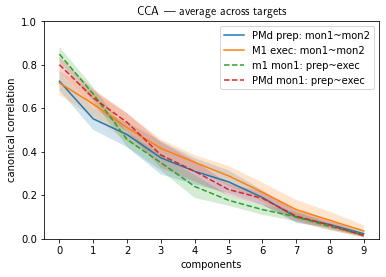

In [6]:
fig,ax = plt.subplots()

CC=[]
for target in range(8):
    dfs_prep = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data_prep]
    dfs_exec = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data_exec]
    
    # PMd prep: mon1~mon2
    CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_prep[1],'PMd_pca'))
    # M1 exec: mon1~mon2
    CC.append(dt.CCA_pyal(dfs_exec[0],'M1_pca', dfs_exec[1],'M1_pca'))
    # m1 mon1: prep~exec
    CC.append(dt.CCA_pyal(dfs_prep[0],'M1_pca', dfs_exec[0],'M1_pca'))
    # PMd mon1: prep~exec
    CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_exec[0],'PMd_pca'))

CC= np.array(CC)

utility.shaded_errorbar(ax,CC[0::4,:].T, label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,CC[1::4,:].T, label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,CC[2::4,:].T,ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,CC[3::4,:].T,ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('canonical correlation')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('CCA --- average across targets', usetex=True);

similar results from prep~exec of Monkey2:


---

what about the VAF?  
I'll look at VAF, instead of correlation, in the plot above

In [13]:
def prep_general (df):
    "preprocessing general!"
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.add_firing_rates(df, 'smooth')
    
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 3)
    df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 3)
    return df_


df_data_ready = [prep_general(df) for  df in df_data]

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', rel_start=-45, rel_end=0)
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', rel_start=0, rel_end=45)

/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


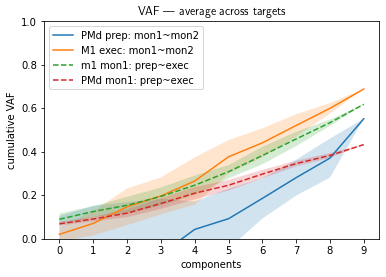

In [8]:
fig,ax = plt.subplots()


CC=[]

for target in range(8):
    # PMd prep: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[1], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=prep_epoch, target2=target)
    CC.append((a+b)/2)

    # M1 exec: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=exec_epoch, target1=target,
                            df2=df_data_ready[1], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # m1 mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # PMd mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)


CC= np.array(CC)

utility.shaded_errorbar(ax,np.cumsum(CC[0::4,:].T,axis=0), label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[1::4,:].T,axis=0), label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[2::4,:].T,axis=0),ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,np.cumsum(CC[3::4,:].T,axis=0),ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('cumulative VAF')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('VAF --- average across targets', usetex=True);

CCa now  is applied to each target separately.  
What if I keep the same number of trials to each target, sort them and then apply CCA to all of it only once?
> I think it makes more sense, because realignment is due to neural turnover, not different targets.

A few test cells below:

In [14]:
df1=df_data_ready[0]
field1='PMd_rates'
epoch1=prep_epoch
target1=3
df2=df_data_ready[1]
field2='PMd_rates'
epoch2=prep_epoch
target2=3


df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
rates_1 = np.concatenate(df1[field1].values, axis=0)
rates_1 -= np.mean(rates_1,axis=0)
rates_1_model = PCA(n_components=10, svd_solver='full').fit(rates_1)
rates_1_C = rates_1_model.components_
df1 = pyal.apply_dim_reduce_model(df1, rates_1_model, field1, '_pca');


df1 = pyal.select_trials(df1, df1.target_id==target1)
pca_1_target = np.concatenate(df1['_pca'].values, axis=0)


df2 = pyal.restrict_to_interval(df2, epoch_fun=epoch2)
rates_2 = np.concatenate(df2[field2].values, axis=0)
rates_2 -= np.mean(rates_2,axis=0)
rates_2_model = PCA(n_components=10, svd_solver='full').fit(rates_2)
rates_2_C = rates_2_model.components_
df2 = pyal.apply_dim_reduce_model(df2, rates_2_model, field2, '_pca');

df2 = pyal.select_trials(df2, df2.target_id==target2)
pca_2_target = np.concatenate(df2['_pca'].values, axis=0)


# same number of timepoints in both matrices
n_samples = min ([pca_1_target.shape[0], pca_2_target.shape[0]])
pca_1_target = pca_1_target[:n_samples,:]
pca_2_target = pca_2_target[:n_samples,:]

A, B, _, _, _ = dt.canoncorr(pca_1_target, pca_2_target, fullReturn=True)
VAFs1 = dt.VAF_pc_cc(rates_1, rates_1_C, A)
VAFs2 = dt.VAF_pc_cc(rates_2, rates_2_C, B)


Text(0.5, 1.0, 'PMd prep: mon1~mon2')

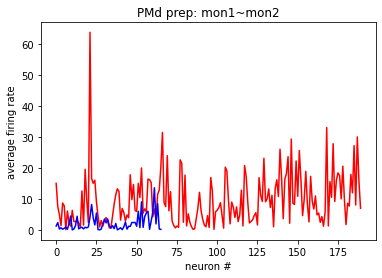

In [15]:
df1 = pyal.restrict_to_interval(df_data_ready[0],epoch_fun=epoch1)
rates_1 = np.concatenate(df1[field1].values, axis=0)
df2 = pyal.restrict_to_interval(df_data_ready[1], epoch_fun=epoch2)
rates_2 = np.concatenate(df2[field2].values, axis=0)
plt.plot(np.mean(rates_1,axis=0),'r')
plt.plot(np.mean(rates_2,axis=0),'b')
plt.xlabel('neuron #')
plt.ylabel('average firing rate')
plt.title('PMd prep: mon1~mon2')

In [16]:
X, C1, A= rates_1, rates_1_C, A
Y, C2, B= rates_2, rates_2_C, B

norm = lambda m:np.sum(m**2)

D1 = linalg.inv(A.T@A)@A.T@C1
E1 = C1.T@A

D2 = linalg.inv(B.T@B)@B.T@C2
E2 = C2.T@B


Y_ = Y @ E2[:,:] @ D2[:,:] 

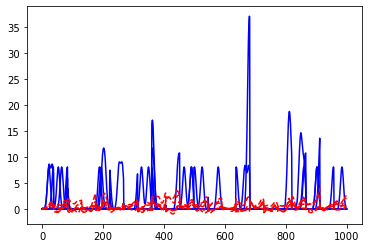

In [23]:
offset = 7000
plt.plot(Y[offset:offset+1000, 15:20],'b');
plt.plot(Y_[offset:offset+1000,15:20],'--r');

look at the the canonical dynamics

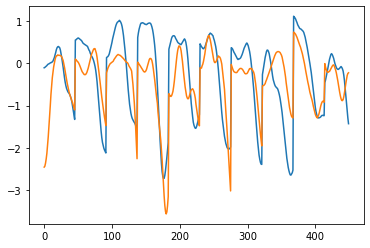

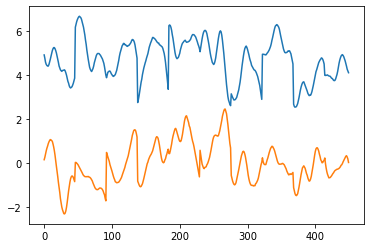

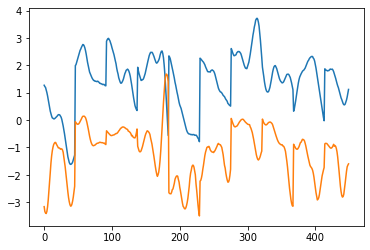

In [24]:
Xc = X @ E1

Yc = Y @ E2

plt.plot(Xc[:450,0])
plt.plot(Yc[:450,0])

plt.figure()
plt.plot(Xc[:450,1])
plt.plot(Yc[:450,1])

plt.figure()
plt.plot(Xc[:450,2])
plt.plot(Yc[:450,2])

plot mthe VAF again, this time all firing rates are *z-score*d

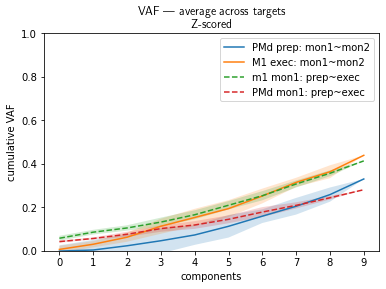

In [23]:
def VAF_pc_cc_pyal(df1:pd.DataFrame, field1: str, epoch1, target1: int,
             df2:pd.DataFrame, field2: str, epoch2, target2: int) -> (np.ndarray, np.ndarray):
    """
    Measure VAF for each CCA axis, between 2 DataFrames, fields, time epochs, and targets.
    epoch1, epoch2: an instance of the `pyal.generate_epoch_fun` function.
    """
    if "target_id" not in df1.columns:
        df1["target_id"] = df1.apply(get_target_id, axis=1)
    if "target_id" not in df2.columns:
        df2["target_id"] = df2.apply(get_target_id, axis=1)
 
    df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
    df1 = pyal.z_score_signal(df1, field1)
    rates_1 = np.concatenate(df1[field1].values, axis=0)
    
    rates_1_model = PCA(n_components=10, svd_solver='full').fit(rates_1)
    rates_1_C = rates_1_model.components_
    df1 = pyal.apply_dim_reduce_model(df1, rates_1_model, field1, '_pca');

    
    df1 = pyal.select_trials(df1, df1.target_id==target1)
    pca_1_target = np.concatenate(df1['_pca'].values, axis=0)

    
    df2 = pyal.restrict_to_interval(df2, epoch_fun=epoch2)
    df2 = pyal.z_score_signal(df2, field2)
    rates_2 = np.concatenate(df2[field2].values, axis=0)
    
    rates_2_model = PCA(n_components=10, svd_solver='full').fit(rates_2)
    rates_2_C = rates_2_model.components_
    df2 = pyal.apply_dim_reduce_model(df2, rates_2_model, field2, '_pca');
    
    df2 = pyal.select_trials(df2, df2.target_id==target2)
    pca_2_target = np.concatenate(df2['_pca'].values, axis=0)
    
    
    # same number of timepoints in both matrices
    n_samples = min ([pca_1_target.shape[0], pca_2_target.shape[0]])
    pca_1_target = pca_1_target[:n_samples,:]
    pca_2_target = pca_2_target[:n_samples,:]

    A, B, r, _, _ = dt.canoncorr(pca_1_target, pca_2_target, fullReturn=True)
    VAFs1 = dt.VAF_pc_cc(rates_1, rates_1_C, A)
    VAFs2 = dt.VAF_pc_cc(rates_2, rates_2_C, B)
    
    return VAFs1, VAFs2, r




fig,ax = plt.subplots()


CC=[]

for target in range(8):
    # PMd prep: mon1~mon2
    a,b,_ = VAF_pc_cc_pyal(df1=df_data_ready[1], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=prep_epoch, target2=target)
    CC.append((a+b)/2)

    # M1 exec: mon1~mon2
    a,b,_ = VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=exec_epoch, target1=target,
                            df2=df_data_ready[1], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # m1 mon1: prep~exec
    a,b,_ = VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # PMd mon1: prep~exec
    a,b,_ = VAF_pc_cc_pyal(df1=df_data_ready[0], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)


CC= np.array(CC)

utility.shaded_errorbar(ax,np.cumsum(CC[0::4,:].T,axis=0), label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[1::4,:].T,axis=0), label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[2::4,:].T,axis=0),ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,np.cumsum(CC[3::4,:].T,axis=0),ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('cumulative VAF')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('VAF --- average across targets\nZ-scored', usetex=True);

Let's look at VAF within monkey and within area between targets, and to the same target and between subsets of trials just to check if we get an elbow:

### VAF by canonical axes between targets

just between pairs of targets

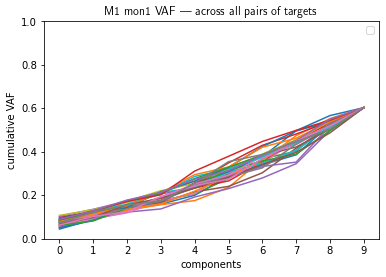

In [16]:
fig,ax = plt.subplots()

CC1=[]
R1 = []
for tar1 in range(8):
    for tar2 in range(tar1+1,8):

        a,b,r = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=exec_epoch, target1=tar1,
                                df2=df_data_ready[0], field2='M1_rates', epoch2=exec_epoch, target2=tar2)
        CC1.append((a+b)/2)
        R1.append(r)

        ax.plot(np.cumsum(CC1[-1]))

ax.set_xlabel('components')
ax.set_ylabel('cumulative VAF')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('M1 mon1 VAF --- across all pairs of targets', usetex=True);

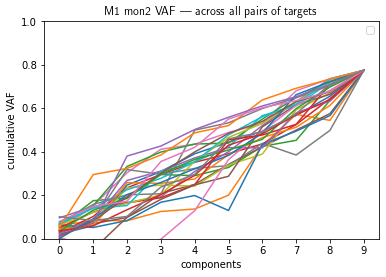

In [17]:
fig,ax = plt.subplots()

CC2=[]
R2 = []
for tar1 in range(8):
    for tar2 in range(tar1+1,8):

        a,b,r = dt.VAF_pc_cc_pyal(df1=df_data_ready[1], field1='M1_rates', epoch1=exec_epoch, target1=tar1,
                                df2=df_data_ready[1], field2='M1_rates', epoch2=exec_epoch, target2=tar2)

        CC2.append((a+b)/2)
        R2.append(r)

        ax.plot(np.cumsum(CC2[-1]))

ax.set_xlabel('components')
ax.set_ylabel('cumulative VAF')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('M1 mon2 VAF --- across all pairs of targets', usetex=True);

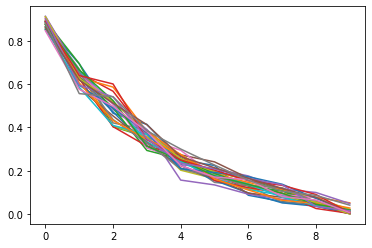

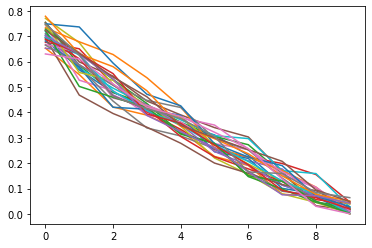

In [18]:
CCs1= np.array(CC1).T
Rs1= np.array(R1).T

CCs2= np.array(CC2).T
Rs2= np.array(R2).T


plt.plot(Rs1);
plt.figure()
plt.plot(Rs2);

In [19]:
df_data_ready[1].M1_rates[0].shape

(1057, 51)

### VAF by canonical axes between subsets of trials to the same targets
